In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.inspection import permutation_importance

# Generate synthetic data
data, name_map = util.generate_data(size=500, seed=42)
num_cols = [c for c in data.columns[:-1] if len(data[c].unique()) > 2]
cat_cols = [c for c in data.columns[:-1] if len(data[c].unique()) == 2]

# Data pre-processing
X, y = data[data.columns[:-1]].copy(), data[data.columns[-1]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Non-Linear Models and Importances

## Dealing with Non-Linearities

**We'll start by switching to a non-linear model**

By doing so:

* We can still account for non-linear correlations
* We can account for interactions among variables
* We might reach a much better accuracy
* ...And hence have a more representative proxy model

**Of course there is a price to pay**

* Non-linear models are less easy to interpret
* ...And they are at a much higher risk of overfitting

## Gradient Boosted Trees Model

**We'll train a Gradient Bossted Trees model**

We'll rely on the Extreme Gradient Boosting package ([XGBoost](https://xgboost.readthedocs.io/en/stable/)) for this

In [2]:
base_est = xgboost.XGBClassifier(tree_method='hist', importance_type='total_gain')
param_grid={'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 41, 5)), 'reg_lambda': np.linspace(0, 500, 6)}
gscv = GridSearchCV(base_est, param_grid=param_grid)
gscv.fit(X, y)
xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

**XGBoost is a library for fast, distributed, training of GBT models**

It has support for _multiple loss functions_

* For classification, the default is "reg:logistic", i.e. binary cross-entropy

...And for _regularization_ (often missing in tree-based models)

* The "reg_lambda" parameter refers to the weight of an L2 regularization term
* ...Which in GBT is applied [to the leaf labels](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

## Gradient Boosted Trees Model

**It's easier to see how regularization work by checking a tree in the ensemble**

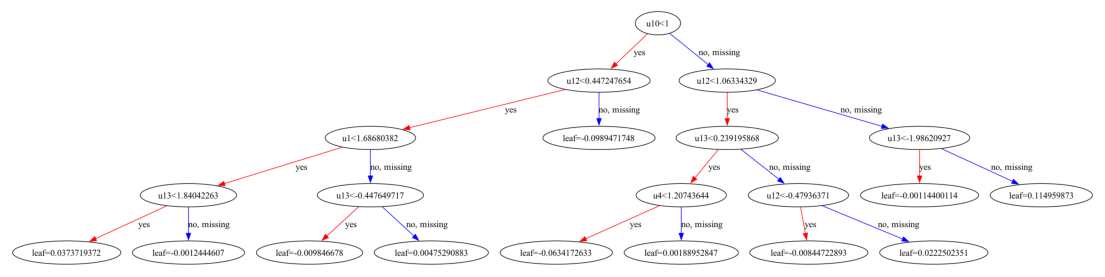

In [5]:
plt.figure(figsize=figsize)
xgboost.plot_tree(xbm, ax=plt.gca(), tree_idx=0);

* Assuming $T$ is the number of leaves and $w_j$ is the label assigned to each leaf
* ...Then the regularization term is in the form $\sum_{k=1}^T w_j^2$

## Gradient Boosted Trees Model

**On our dataset, a GBT model has substantially better performance**

In [6]:
xbm_score_cv, xbm_score_test = gscv.best_score_, roc_auc_score(y_test, xbm.predict(X_test))
print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-val.), {xbm_score_test:.2f} (test)')

AUC score for {'max_depth': 4, 'n_estimators': 25, 'reg_lambda': np.float64(100.0)}: 0.73 (cross-val.), 0.70 (test)


* The AUC score is much higher now
* There is no significant overfitting

**It seems we finally have a model that we can trust**

However, we know have an ensemble of many non-linear models

> **How can we make sense of that?**

## Feature Importances

**The first option one can probably think of is using _feature importances_**

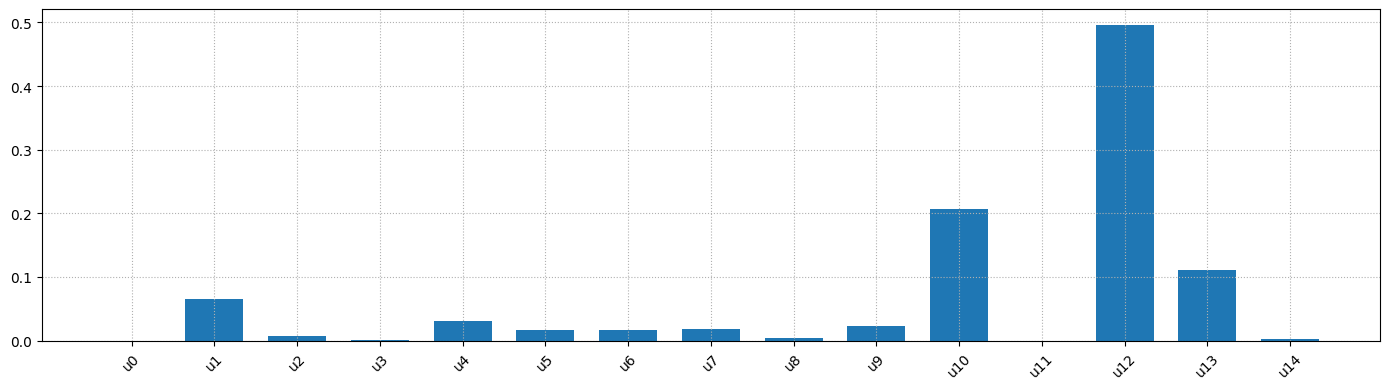

In [7]:
xbm_imp = pd.Series(index=X.columns, data=xbm.feature_importances_)
util.plot_bars(xbm_imp, figsize=figsize)

* The scores differ significanly from those obtained for linear regression (as expected)
* ...But what do they represent?

## Which Feature Importances?

**Feature importance is typicaly presented as this:**

* For each input $x_j$, we sum the associated _gain_ at training time
* Once training is over, we normalize the scores so that they sum up to 1

**Howver, there are _other ways to define importance_**

XGBoost supports 5 different approaches:

* "weight": number of times an attribute is used to split
* "gain": average gain associated to splits over an attribute
* "cover": average number of examples for which an attribute is used to decide
* "total_gain": as above, but replacing the average with a sum
* "total_cover": as above, but replacing the average with a sum

## Which Feature Importances?

**The values of the multiple feature importances can be quite different:**

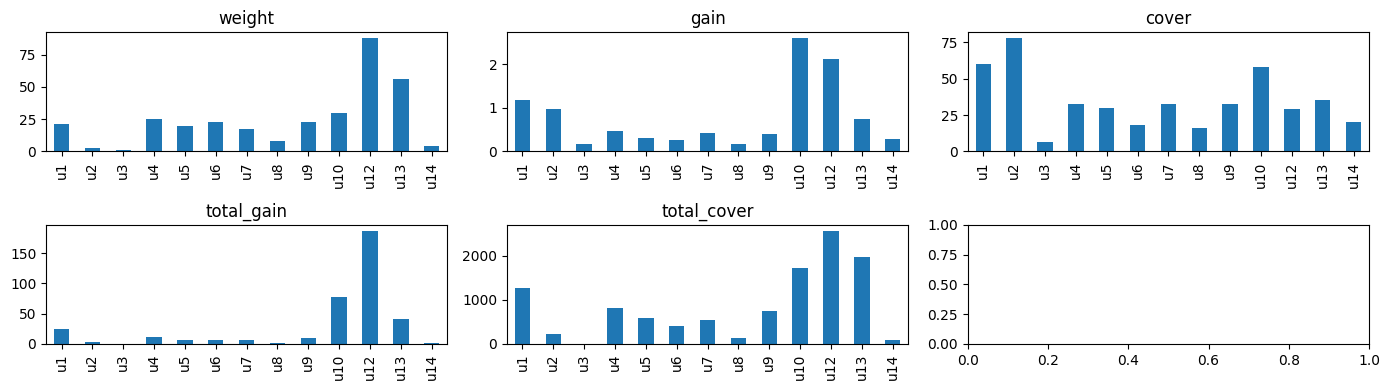

In [8]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=figsize)
for ax, imp_type in zip(axes.ravel(), ['weight', 'gain', 'cover', 'total_gain', 'total_cover']):
    pd.Series(xbm.get_booster().get_score(importance_type=imp_type)).plot.bar(ax=ax, title=imp_type)
plt.tight_layout()

## Importance and Data

**Moreover, most importance scores are computed _w.r.t. a dataset:_**

E.g. in XGBoost "gain", "cover", "total_gain", and "total_cover"

* For this reason, they are not really properties of the model
* ...But rather of the model and a reference sample

This means that the score semantic _depends on the reference sample_

**By default, importances are computed on the training set**

...Which means they are susceptible to overfitting

* The model might split on an attribute because it really is importance
* ...But also due to a [spurious correlation](https://www.tylervigen.com/spurious-correlations)

## Permutation Importance

**We can improve things by changing the way we compute importance**

Given a reference sample $\{x_i, y_i\}_{i=1}^m$

* We can evaluate the performance of our model on the sample
* ...With that of a modified sample where the $j$-th input is _made_ unimportant

**For example, we can achieve that by _permuting_ the values of the input**

* This will preserve the distribution of the input
* ...But it will break all its correlations

**Then, we look at the change in the model performance**

* If it is small, the attribute is really unimportant
* Otherwise, the attribute is important

**These scores are known as _permutation importances_**

## Permutation Importance

**Permutation importances are robust w.r.t. spurious correlations**

* We just need to repeat the process multiple times
* ...And record means and standard deviations

It's unlikely that we often get a high score by accident

**They allow us to _choose_ our reference sample:**

On the _training_ set, the model might have overfit over the data

* The performance gap will be wider
* ...And the score will reflect how the model _is using_ the data

On the _test set_, overfitting will make less of a different

* ...And the score will reflect how correlated the attribute is with the target

## Permutation Importances, on our Example

**Let's check the _training_ permutation importances in our case study**

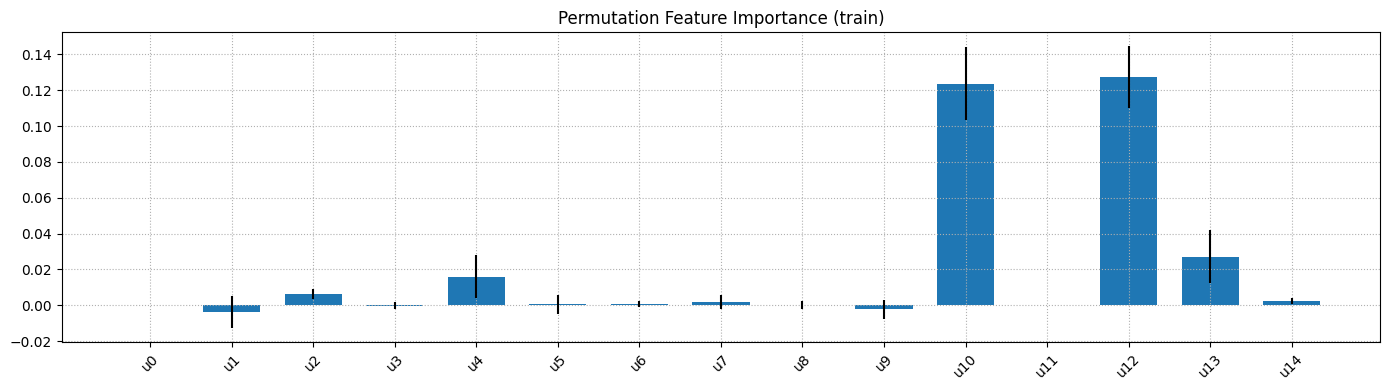

In [9]:
r_train = permutation_importance(xbm, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)
util.plot_bars(xbm_p_imp, figsize=figsize, std=r_train.importances_std, title='Permutation Feature Importance (train)')

* The closely resemble those XGB "total_gain", but they are more sparse

## Permutation Importances, on our Example

**Let's check the _test_ permutation importances in our case study**

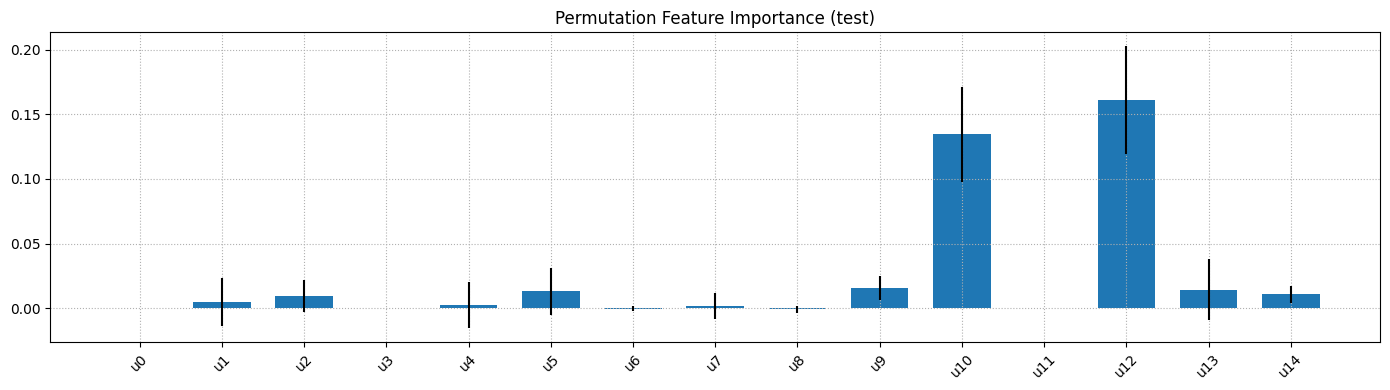

In [10]:
r_test = permutation_importance(xbm, X_test, y_test, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_test.importances_mean)
util.plot_bars(xbm_p_imp, figsize=figsize, std=r_test.importances_std, title='Permutation Feature Importance (test)')

* A few low-importance features become even less relevant on the test data